### Классификация изображений

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Решаем достаточно известную задачу классификации персонажей всем известного мультсериала.

Задача:
1. Целевая метрика - accuracy;
2. Минимальное требуемое значения метрики - 0.83;
3. Визуальная проверка результатов на тесте.

Кроме построения нейросети и оценки её качества необходимо:
- замерять время обучения сети;
- написать функцию, которая на вход будет принимать ссылку на произвольное изображение и прогнозировать его класс;
- написать код, который будет выводть 9 случайных изображений из теста с их фактическими и прогнозными классами.

#### 1. Загрузка данных

Данные можно скачать по [ссылке](https://disk.yandex.ru/d/U9bpivZ-Tpknfw).

In [1]:
!pip install wldhx.yadisk-direct
!curl -L $(yadisk-direct https://disk.yandex.ru/d/U9bpivZ-Tpknfw) -o simspons.zip
!unzip -qq simspons.zip

Defaulting to user installation because normal site-packages is not writeable
<!doctype html><html prefix="og: http://ogp.me/ns#" lang="ru"><meta http-equiv="X-UA-Compatible" content="IE=edge"><meta charset="utf-8"><meta name="viewport" content="width=device-width,initial-scale=1"><title data-react-helmet="true">Вы не робот?</title><meta data-react-helmet="true" property="og:title" content="Яндекс"><meta data-react-helmet="true" property="og:description" content="Найдётся всё"><meta data-react-helmet="true" property="og:image" content="https://yastatic.net/s3/home-static/_/37/37a02b5dc7a51abac55d8a5b6c865f0e.png"><link rel="stylesheet" href="/captcha_smart.bad0b1be15caa82f8807.min.css?k=1724945227620"><style>@media only screen and (min-width:651px) and (prefers-color-scheme:light){body{background-image:url('https://captcha-backgrounds.s3.yandex.net/static/default-background.jpg')}.LogoLink{background-image:url('https://cdnrhkgfkkpupuotntfj.svc.cdn.yandex.net/yandexrulogo.svg')}}@media 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0curl: (6) Could not resolve host: $(yadisk-direct
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 12802  100 12802    0     0  49982      0 --:--:-- --:--:-- --:--:-- 49982
unzip:  cannot find either simspons.zip or simspons.zip.zip.


In [ ]:
# Импорт библиотек

import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torchvision
import shutil
from PIL import Image
from pathlib import Path
from collections import Counter
from torchvision import datasets, models, transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

import seaborn as sns

torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##### Даталоадер

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:<br><br>
$input = \frac{input - \mu}{\text{standard deviation}} $, <br><br>

константы - средние и дисперсии по каналам на основе ImageNet.<br>

Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. Картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample).

In [3]:
# Hазные режимы загрузки датасета
data_modes = ['train', 'val', 'test']

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [4]:
# Чиатем данные
train_dir = Path('journey-springfield/train/simpsons_dataset')
test_dir = Path('journey-springfield/testset/testset')

train_val_files = list(train_dir.rglob('*.jpg'))
test_files = list(test_dir.rglob('*.jpg'))

In [5]:
# Разделяем на выборки 
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

In [6]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [ ]:
# Определим функции для отображения картинок и выведем 9 случайных из трейна
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt_ax.imshow(inp)
    plt_ax.set_title(title)


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

#### 2. Обзор данных, анализ дисбаланса классов

In [8]:
# Количество и наименование классов
class_names = train_dataset.label_encoder.classes_
print(len(class_names))
print(class_names)

42
['abraham_grampa_simpson' 'agnes_skinner' 'apu_nahasapeemapetilon'
 'barney_gumble' 'bart_simpson' 'carl_carlson' 'charles_montgomery_burns'
 'chief_wiggum' 'cletus_spuckler' 'comic_book_guy' 'disco_stu'
 'edna_krabappel' 'fat_tony' 'gil' 'groundskeeper_willie' 'homer_simpson'
 'kent_brockman' 'krusty_the_clown' 'lenny_leonard' 'lionel_hutz'
 'lisa_simpson' 'maggie_simpson' 'marge_simpson' 'martin_prince'
 'mayor_quimby' 'milhouse_van_houten' 'miss_hoover' 'moe_szyslak'
 'ned_flanders' 'nelson_muntz' 'otto_mann' 'patty_bouvier'
 'principal_skinner' 'professor_john_frink' 'rainier_wolfcastle'
 'ralph_wiggum' 'selma_bouvier' 'sideshow_bob' 'sideshow_mel'
 'snake_jailbird' 'troy_mcclure' 'waylon_smithers']


In [9]:
# Объем тренировочной выборки
len(train_files)

15699

In [10]:
# Посмотрим на количество объектов в каждом классе тренировочной выборки
from collections import Counter

train_labels = [path.parent.name for path in train_files]
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")

Количество объектов в каждом классе тренировочной выборки:
Класс lisa_simpson, количество 1015, доля 6.47%
Класс lenny_leonard, количество 233, доля 1.48%
Класс comic_book_guy, количество 352, доля 2.24%
Класс principal_skinner, количество 895, доля 5.70%
Класс krusty_the_clown, количество 904, доля 5.76%
Класс apu_nahasapeemapetilon, количество 467, доля 2.97%
Класс homer_simpson, количество 1684, доля 10.73%
Класс chief_wiggum, количество 739, доля 4.71%
Класс sideshow_bob, количество 658, доля 4.19%
Класс bart_simpson, количество 1006, доля 6.41%
Класс ned_flanders, количество 1090, доля 6.94%
Класс milhouse_van_houten, количество 809, доля 5.15%
Класс marge_simpson, количество 968, доля 6.17%
Класс charles_montgomery_burns, количество 895, доля 5.70%
Класс ralph_wiggum, количество 67, доля 0.43%
Класс abraham_grampa_simpson, количество 685, доля 4.36%
Класс edna_krabappel, количество 343, доля 2.18%
Класс moe_szyslak, количество 1089, доля 6.94%
Класс nelson_muntz, количество 269, 

> Видим явный дисбаланс классов, для борьбы с ним выделим миноритарные классы для последующего применения аугментации

#### 3. Борьба с дисбалансом: аугментация миноритарных классов

In [11]:
# Подсчитаем среднее число объектов в классе для того, чтобы провести черту между миноритарными и мажоритарными классами
mean_class_count = sum(train_counter.values()) / len(train_counter)
print(f"Среднее количество объектов в классе: {mean_class_count}")

Среднее количество объектов в классе: 373.7857142857143


In [12]:
# Выделим миноритарные классы
minority_class = [class_name for class_name, count in train_counter.items() if count < mean_class_count]
print(minority_class)

['lenny_leonard', 'comic_book_guy', 'ralph_wiggum', 'edna_krabappel', 'nelson_muntz', 'sideshow_mel', 'barney_gumble', 'selma_bouvier', 'waylon_smithers', 'groundskeeper_willie', 'snake_jailbird', 'professor_john_frink', 'mayor_quimby', 'fat_tony', 'carl_carlson', 'kent_brockman', 'maggie_simpson', 'rainier_wolfcastle', 'martin_prince', 'patty_bouvier', 'otto_mann', 'agnes_skinner', 'cletus_spuckler', 'gil', 'lionel_hutz', 'disco_stu', 'miss_hoover', 'troy_mcclure']


In [13]:
# Переопределим класс SimsonsDataset с применением аугментации только к миноритарным классам тренировочной выорки

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    # создаём метод для аугментаций
    def augment_image(self, x):
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.TrivialAugmentWide(num_magnitude_bins=5),
            transforms.ToTensor()
        ])(x)

    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            # применяем аугментацию только к миноритарным классам
            if label in minority_class:
                x = self.augment_image(x)
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)


In [14]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

In [15]:
# Создание списка весов и преобразование к тензору для передачи в функцию потерь кросс-энтропии
class_frequency = {class_name: count / len(train_labels) for class_name, count in train_counter.items()}
class_weights = [1.0 / class_frequency[class_name] for class_name in train_counter.keys()]
weights = torch.tensor(class_weights, dtype=torch.float32)

#### 4. Разделение на батчи

In [16]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                             batch_size=32,
                             shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                             batch_size=32,
                             shuffle=False)
train_loader, val_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x22489d1b150>,
 <torch.utils.data.dataloader.DataLoader at 0x22489b69bd0>)

In [17]:
# Проверка батча
img, label = next(iter(train_loader))
print(f"Размерность изображения: {img.shape} -> [размер батча, цветовые каналы, высота, ширина]")

Размерность изображения: torch.Size([32, 3, 224, 224]) -> [размер батча, цветовые каналы, высота, ширина]


#### 5. Transfer learning

In [18]:
# Создание функции обучения с замером времени и функции оценки
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    model.to(device)
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Эпоха {epoch+1}')
        val_loss, val_accuracy = evaluate(model, val_loader, loss_fn)
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Время обучения: {train_time} секунд")
    return model, train_time
def evaluate(model, data_loader, loss_fn):
    total_loss = 0
    correct = 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            pred = torch.argmax(pred, dim=1)
            correct += torch.sum(pred == y).item()
    mean_loss = total_loss / len(data_loader)
    accuracy = correct / len(data_loader.dataset)

    print(f"Функция потерь (кросс-энтропия) на данных {mean_loss}")
    print(f"Точность на данных {accuracy}")

    return mean_loss, accuracy

In [19]:
# Функция вывода матрицы ошибок
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                      index=class_names,
                      columns=class_names)
    plt.figure(figsize=(20, 16))
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')
    plt.show()

In [20]:
# Загрузка предобученных моделей, замена выходного слоя
weights_AlexNet= models.AlexNet_Weights.DEFAULT
model_AlexNet = models.alexnet(weights=weights_AlexNet)
model_AlexNet.classifier[6] = nn.Linear(4096, len(class_names))

weights_VGG19 = models.VGG19_Weights.DEFAULT
model_VGG19 = models.vgg19(weights=weights_VGG19)
model_VGG19.classifier[6] = nn.Linear(4096, len(class_names))

weights_ResNet = models.ResNet18_Weights.DEFAULT
model_ResNet = models.resnet18(weights=weights_ResNet)
model_ResNet.fc = nn.Linear(512, len(class_names))

In [21]:
# Обучение предобученной модели
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [22]:
weights = weights.to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=weights)

##### Модель AlexNet

In [23]:
optimizer = torch.optim.Adam(model_AlexNet.parameters(), lr=1e-4)
model_AlexNet, train_time = train(model_AlexNet, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.6895788198141415
Точность на данных 0.5353458158196408
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.5235141703148
Точность на данных 0.6207489491784486
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.3618399705365158
Точность на данных 0.7017577378677875
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.175710863219028
Точность на данных 0.7122659533817348
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.1891846521345526
Точность на данных 0.7084447841039359
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.143195375835459
Точность на данных 0.7596484524264425
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.8720147348129875
Точность на данных 0.7883072220099351
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.4560225278159546
Точность на данных 0.7273595720290409
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.04360863491641
Точность на данных 0.7672907909820404
Эпоха 10
Функция потерь (кросс-энтропия) на 

In [24]:
ALEXNET0 = MODEL_PATH / "alexnet_model_0.pth"
torch.save(obj=model_AlexNet.state_dict(),
           f=ALEXNET0)


##### Модель VGG19

In [25]:
optimizer = torch.optim.Adam(model_VGG19.parameters(), lr=1e-4)
model_VGG19, train_time = train(model_VGG19, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 2.149532048660792
Точность на данных 0.530569354222392
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.1901580756310113
Точность на данных 0.696217042414979
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.1066949569940223
Точность на данных 0.7128391287734046
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.0955578164642783
Точность на данных 0.7256400458540313
Эпоха 5
Функция потерь (кросс-энтропия) на данных 1.227479506179523
Точность на данных 0.7145586549484142
Эпоха 6
Функция потерь (кросс-энтропия) на данных 1.1862720049743485
Точность на данных 0.7174245319067635
Эпоха 7
Функция потерь (кросс-энтропия) на данных 1.05743391046776
Точность на данных 0.745892243026366
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.4891615442047401
Точность на данных 0.6161635460450898
Эпоха 9
Функция потерь (кросс-энтропия) на данных 1.1180288344504288
Точность на данных 0.7583110431792128
Эпоха 10
Функция потерь (кросс-энтропия) на 

In [26]:
VGG190 = MODEL_PATH / "vgg19_model_0.pth"
torch.save(obj=model_VGG19.state_dict(),
           f=VGG190)


##### Модель ResNet

In [27]:
optimizer = torch.optim.Adam(model_ResNet.parameters(), lr=1e-4)
model_ResNet, train_time = train(model_ResNet, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.2543037431364277
Точность на данных 0.6868551776843714
Эпоха 2
Функция потерь (кросс-энтропия) на данных 1.0196316504587275
Точность на данных 0.7437905999235767
Эпоха 3
Функция потерь (кросс-энтропия) на данных 1.3579474746256948
Точность на данных 0.6828429499426825
Эпоха 4
Функция потерь (кросс-энтропия) на данных 1.0227718779462531
Точность на данных 0.7401604891096676
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.9282795340922291
Точность на данных 0.7678639663737103
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.773308666633306
Точность на данных 0.7963316774933129
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.7585098073168811
Точность на данных 0.8003439052350019
Эпоха 8
Функция потерь (кросс-энтропия) на данных 1.0279670820882436
Точность на данных 0.7457011845624761
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.6354675040945776
Точность на данных 0.8379824226213222
Эпоха 10
Функция потерь (кросс-энтропи

In [28]:
RESNET = MODEL_PATH / "resnet_model_0.pth"
torch.save(obj=model_ResNet.state_dict(),
           f=RESNET)


In [29]:
accuracy_AlexNet = round(evaluate(model_AlexNet, val_loader, loss_fn)[1],2)
accuracy_VGG19 = round(evaluate(model_VGG19, val_loader, loss_fn)[1],2)
accuracy_ResNet = round(evaluate(model_ResNet, val_loader, loss_fn)[1],2)

Функция потерь (кросс-энтропия) на данных 0.8418114468130984
Точность на данных 0.815437523882308
Функция потерь (кросс-энтропия) на данных 1.0889760999370846
Точность на данных 0.7636606801681315
Функция потерь (кросс-энтропия) на данных 0.7368892556854594
Точность на данных 0.8175391669850974


In [30]:
results = pd.DataFrame(columns=['model', 'accuracy', 'time'])

In [31]:
AlexNet_results = {'model': 'AlexNet', 'accuracy': {accuracy_AlexNet}, 'time': '1752'}
results.loc[len(results)] = AlexNet_results
VGG19_results = {'model': 'VGG19', 'accuracy': {accuracy_VGG19}, 'time': '4994'}
results.loc[len(results)] = VGG19_results
ResNet_results = {'model': 'ResNet', 'accuracy': {accuracy_ResNet}, 'time': '1841'}
results.loc[len(results)] = ResNet_results

In [32]:
print(results)

     model accuracy  time
0  AlexNet   {0.82}  1752
1    VGG19   {0.76}  4994
2   ResNet   {0.82}  1841


##### Матрицы ошибок моделей

AlexNet

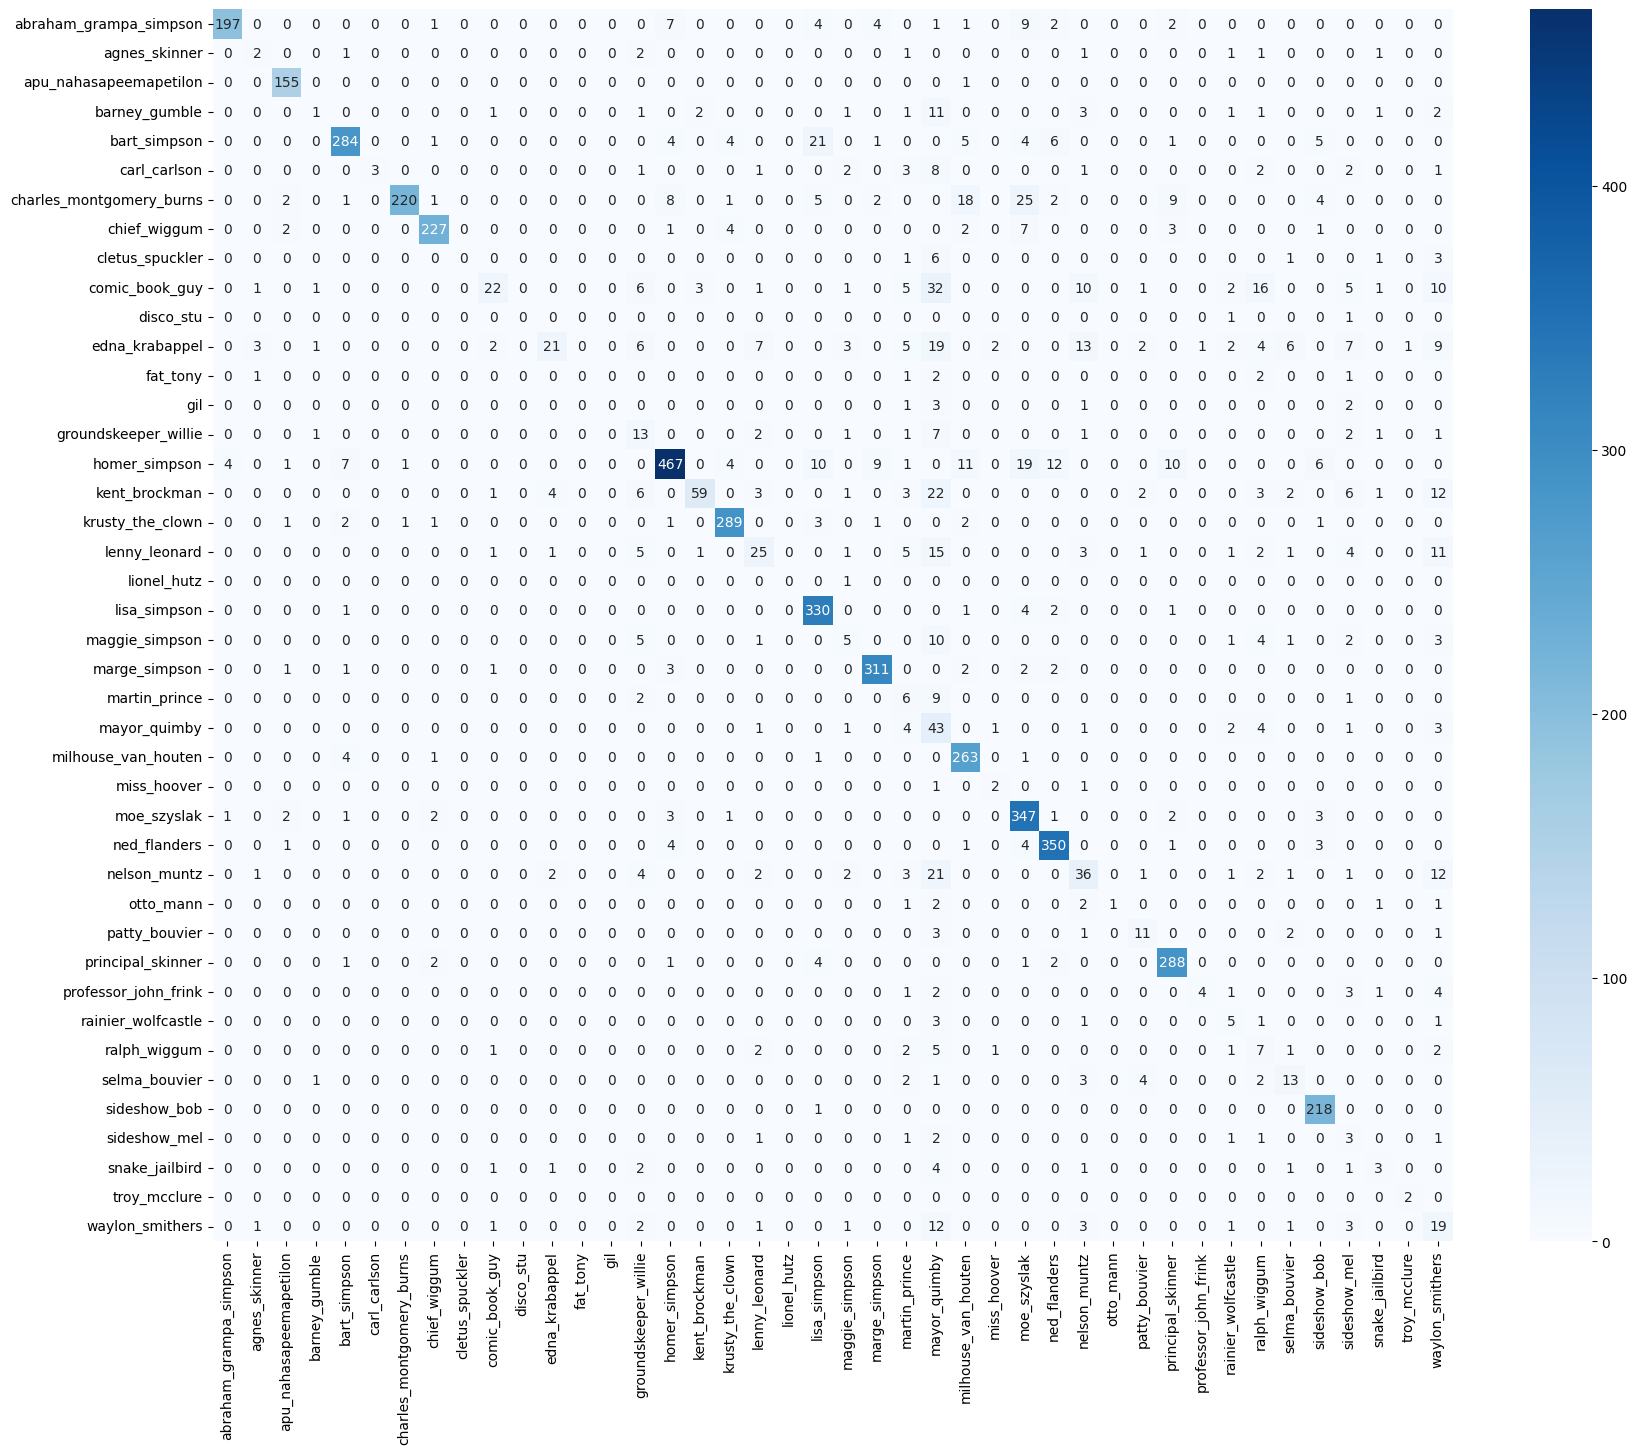

In [33]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_AlexNet(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

VGG19

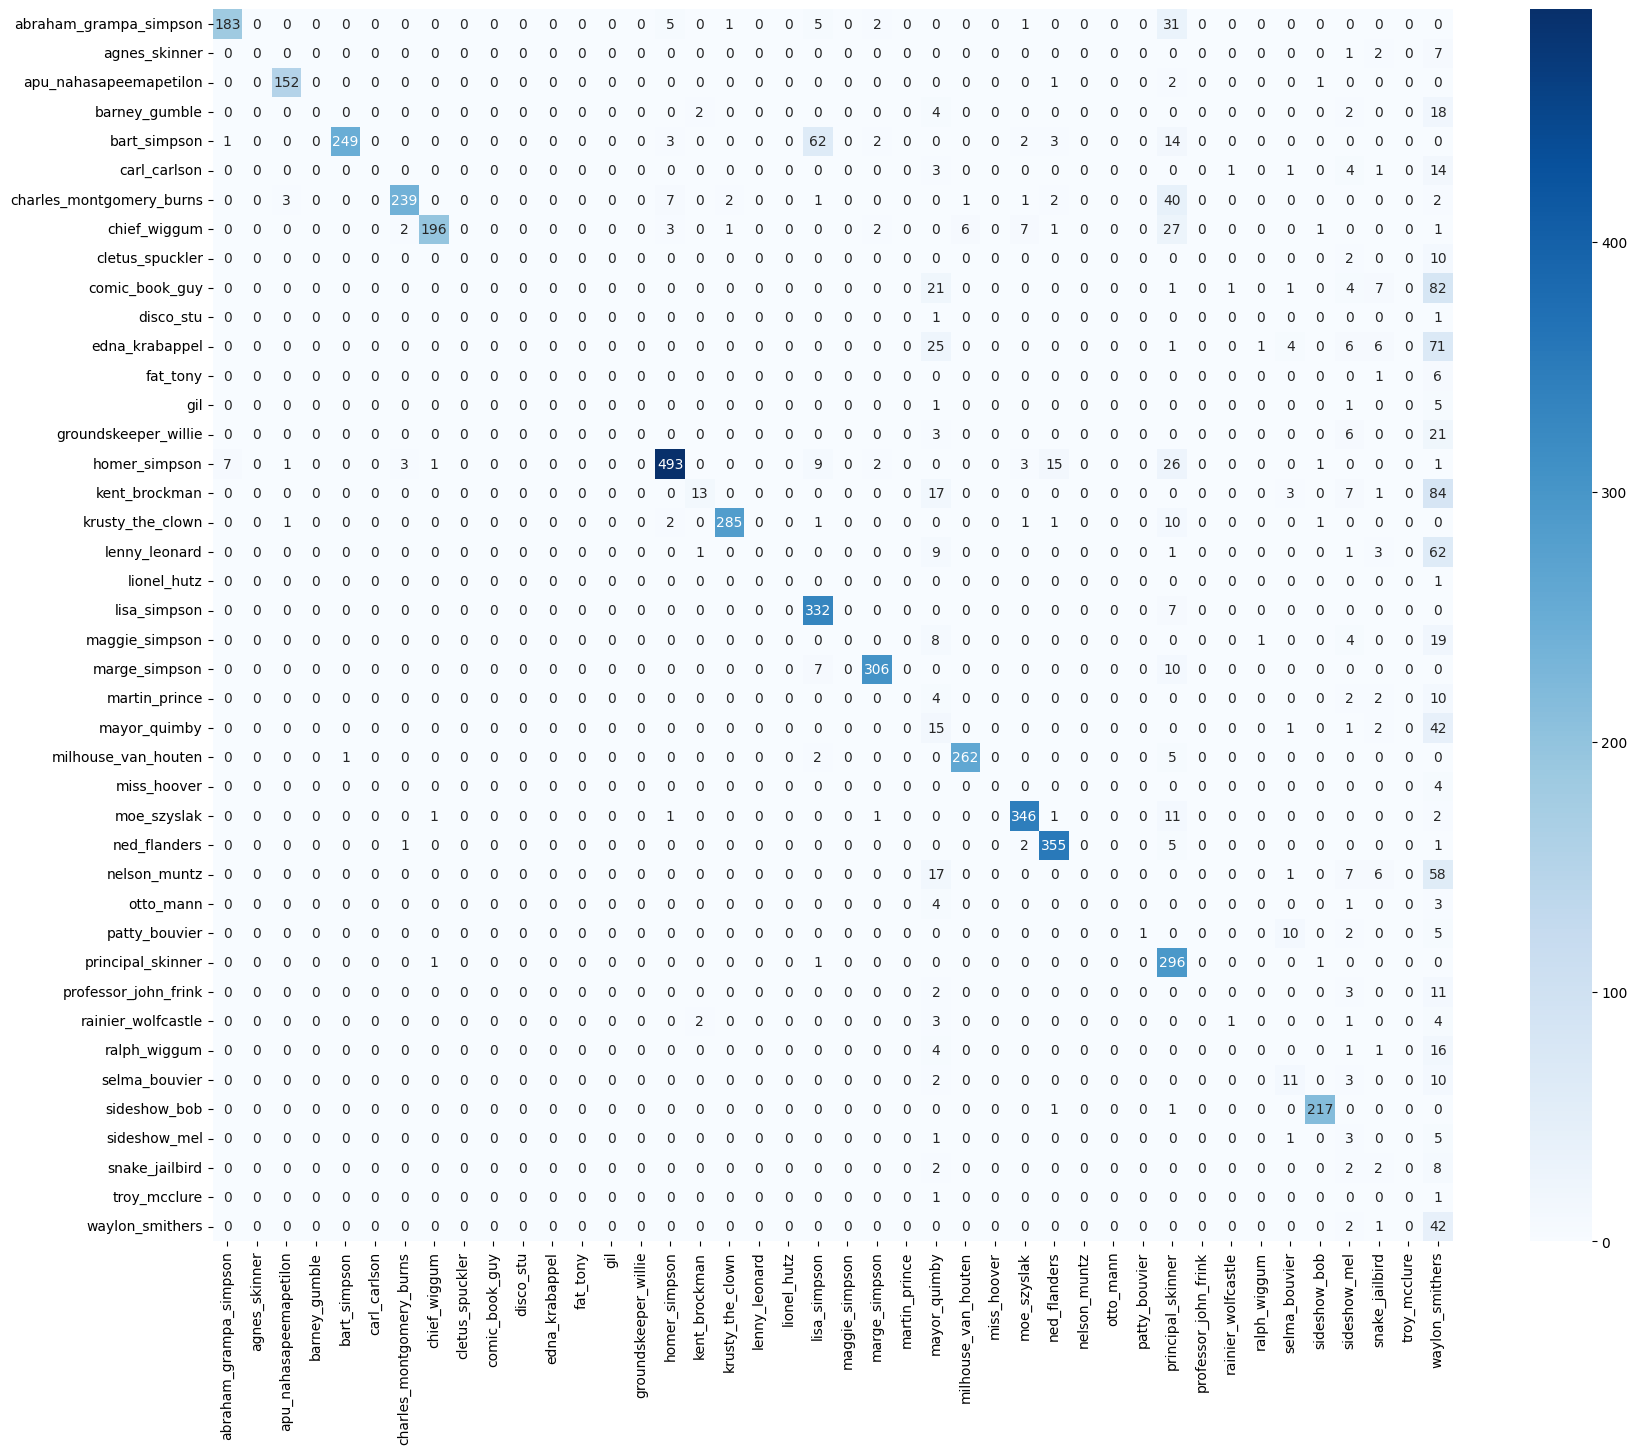

In [34]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_VGG19(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

ResNet

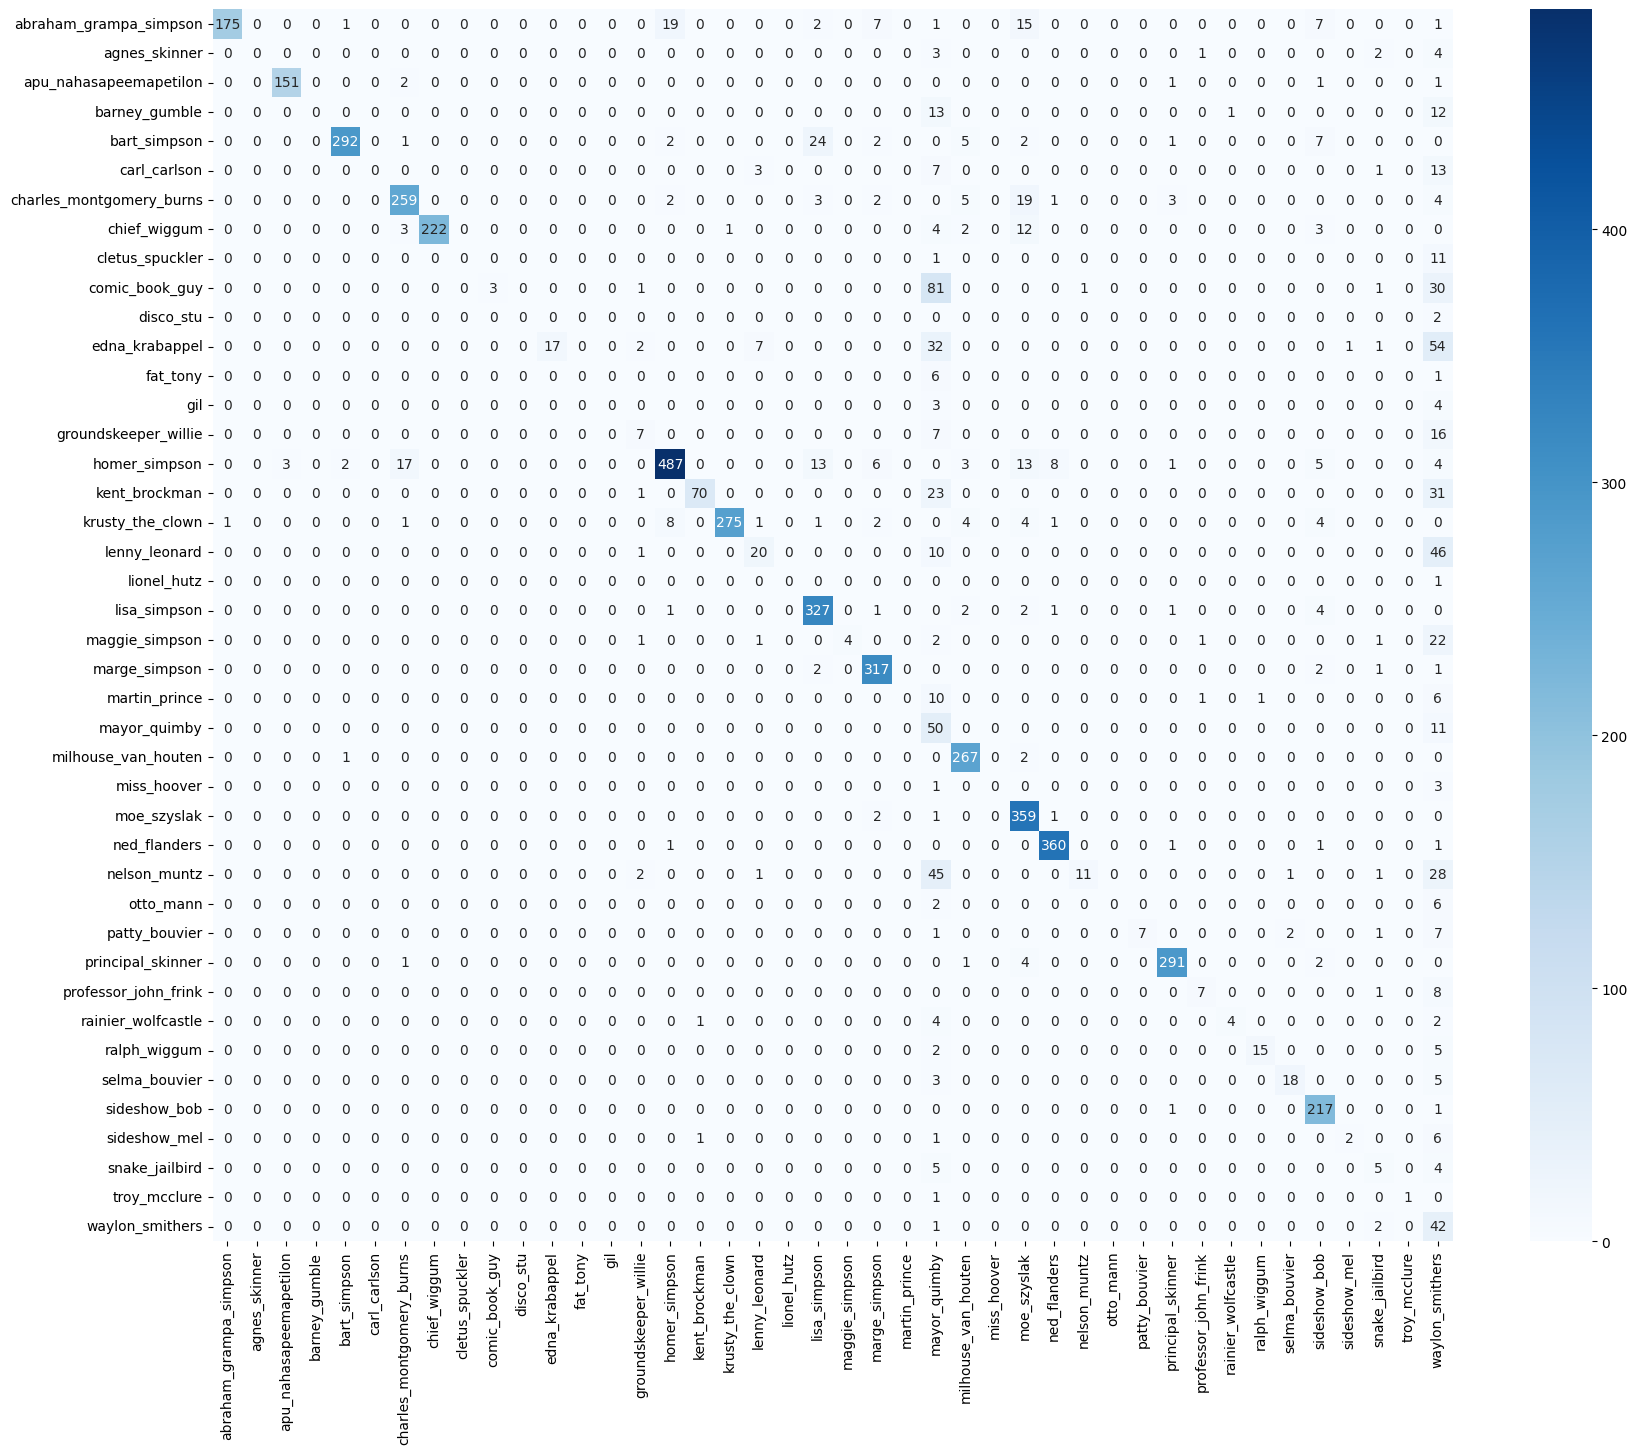

In [35]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_ResNet(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

> Ни одна из моделей не имеет достаточную точность: некоторые классы не определяются, а значит аугментация и балансировка классов не помогли, попробуем выполнить RandomOverSampling

#### 6. OverSamlping

In [36]:
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
from torch.utils.data import WeightedRandomSampler
# Получим метки для train файлов
train_labels = [path.parent.name for path in train_files]

# Применим oversampling
ros = RandomOverSampler()
train_files_resampled, train_labels_resampled = ros.fit_resample(
    np.array(train_files).reshape(-1, 1), train_labels
)

# Преобразуем обратно в список путей
train_files_resampled = [Path(f[0]) for f in train_files_resampled]



Defaulting to user installation because normal site-packages is not writeable


In [37]:
train_labels = [path.parent.name for path in train_files_resampled]
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files_resampled):.2f}%")



Количество объектов в каждом классе тренировочной выборки:
Класс lisa_simpson, количество 1684, доля 2.38%
Класс lenny_leonard, количество 1684, доля 2.38%
Класс comic_book_guy, количество 1684, доля 2.38%
Класс principal_skinner, количество 1684, доля 2.38%
Класс krusty_the_clown, количество 1684, доля 2.38%
Класс apu_nahasapeemapetilon, количество 1684, доля 2.38%
Класс homer_simpson, количество 1684, доля 2.38%
Класс chief_wiggum, количество 1684, доля 2.38%
Класс sideshow_bob, количество 1684, доля 2.38%
Класс bart_simpson, количество 1684, доля 2.38%
Класс ned_flanders, количество 1684, доля 2.38%
Класс milhouse_van_houten, количество 1684, доля 2.38%
Класс marge_simpson, количество 1684, доля 2.38%
Класс charles_montgomery_burns, количество 1684, доля 2.38%
Класс ralph_wiggum, количество 1684, доля 2.38%
Класс abraham_grampa_simpson, количество 1684, доля 2.38%
Класс edna_krabappel, количество 1684, доля 2.38%
Класс moe_szyslak, количество 1684, доля 2.38%
Класс nelson_muntz, кол

In [38]:
train_dataset = SimpsonsDataset(train_files_resampled, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Теперь все классы выровнены, попробуем использовать модель ResNet, которая показала лучшее соотношение метрики и времени в прошлый раз

In [39]:
model_ResNet_2 = models.resnet18(weights=weights_ResNet)
model_ResNet_2.fc = nn.Linear(512, len(class_names))

In [40]:
optimizer = torch.optim.Adam(model_ResNet_2.parameters(), lr=1e-4)
model_ResNet_2, train_time = train(model_ResNet_2, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 1.049539557610931
Точность на данных 0.7030951471150172
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.9468950944626863
Точность на данных 0.7470385938097057
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.7067177203693301
Точность на данных 0.8226977455101261
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.7144488322838612
Точность на данных 0.8221245701184563
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.7337774935655511
Точность на данных 0.8030187237294613
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.5775297526095369
Точность на данных 0.8595720290408865
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.6697116322293178
Точность на данных 0.8507833397019487
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.6351675941101159
Точность на данных 0.8675964845242644
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.8548174935206384
Точность на данных 0.7988154375238823
Эпоха 10
Функция потерь (кросс-энтропи

In [41]:
RESNET2 = MODEL_PATH / "resnet_model_2.pth"
torch.save(obj=model_ResNet_2.state_dict(),
           f=RESNET2)


In [42]:
accuracy_ResNet_2 = round(evaluate(model_ResNet_2, val_loader, loss_fn)[1],2)
ResNet_2_results = {'model': 'ResNet oversampling', 'accuracy': {accuracy_ResNet_2}, 'time': '7964'}
results.loc[len(results)] = ResNet_2_results

Функция потерь (кросс-энтропия) на данных 0.8742695506960392
Точность на данных 0.8328238440962935


In [43]:
print(results)

                 model accuracy  time
0              AlexNet   {0.82}  1752
1                VGG19   {0.76}  4994
2               ResNet   {0.82}  1841
3  ResNet oversampling   {0.83}  7964


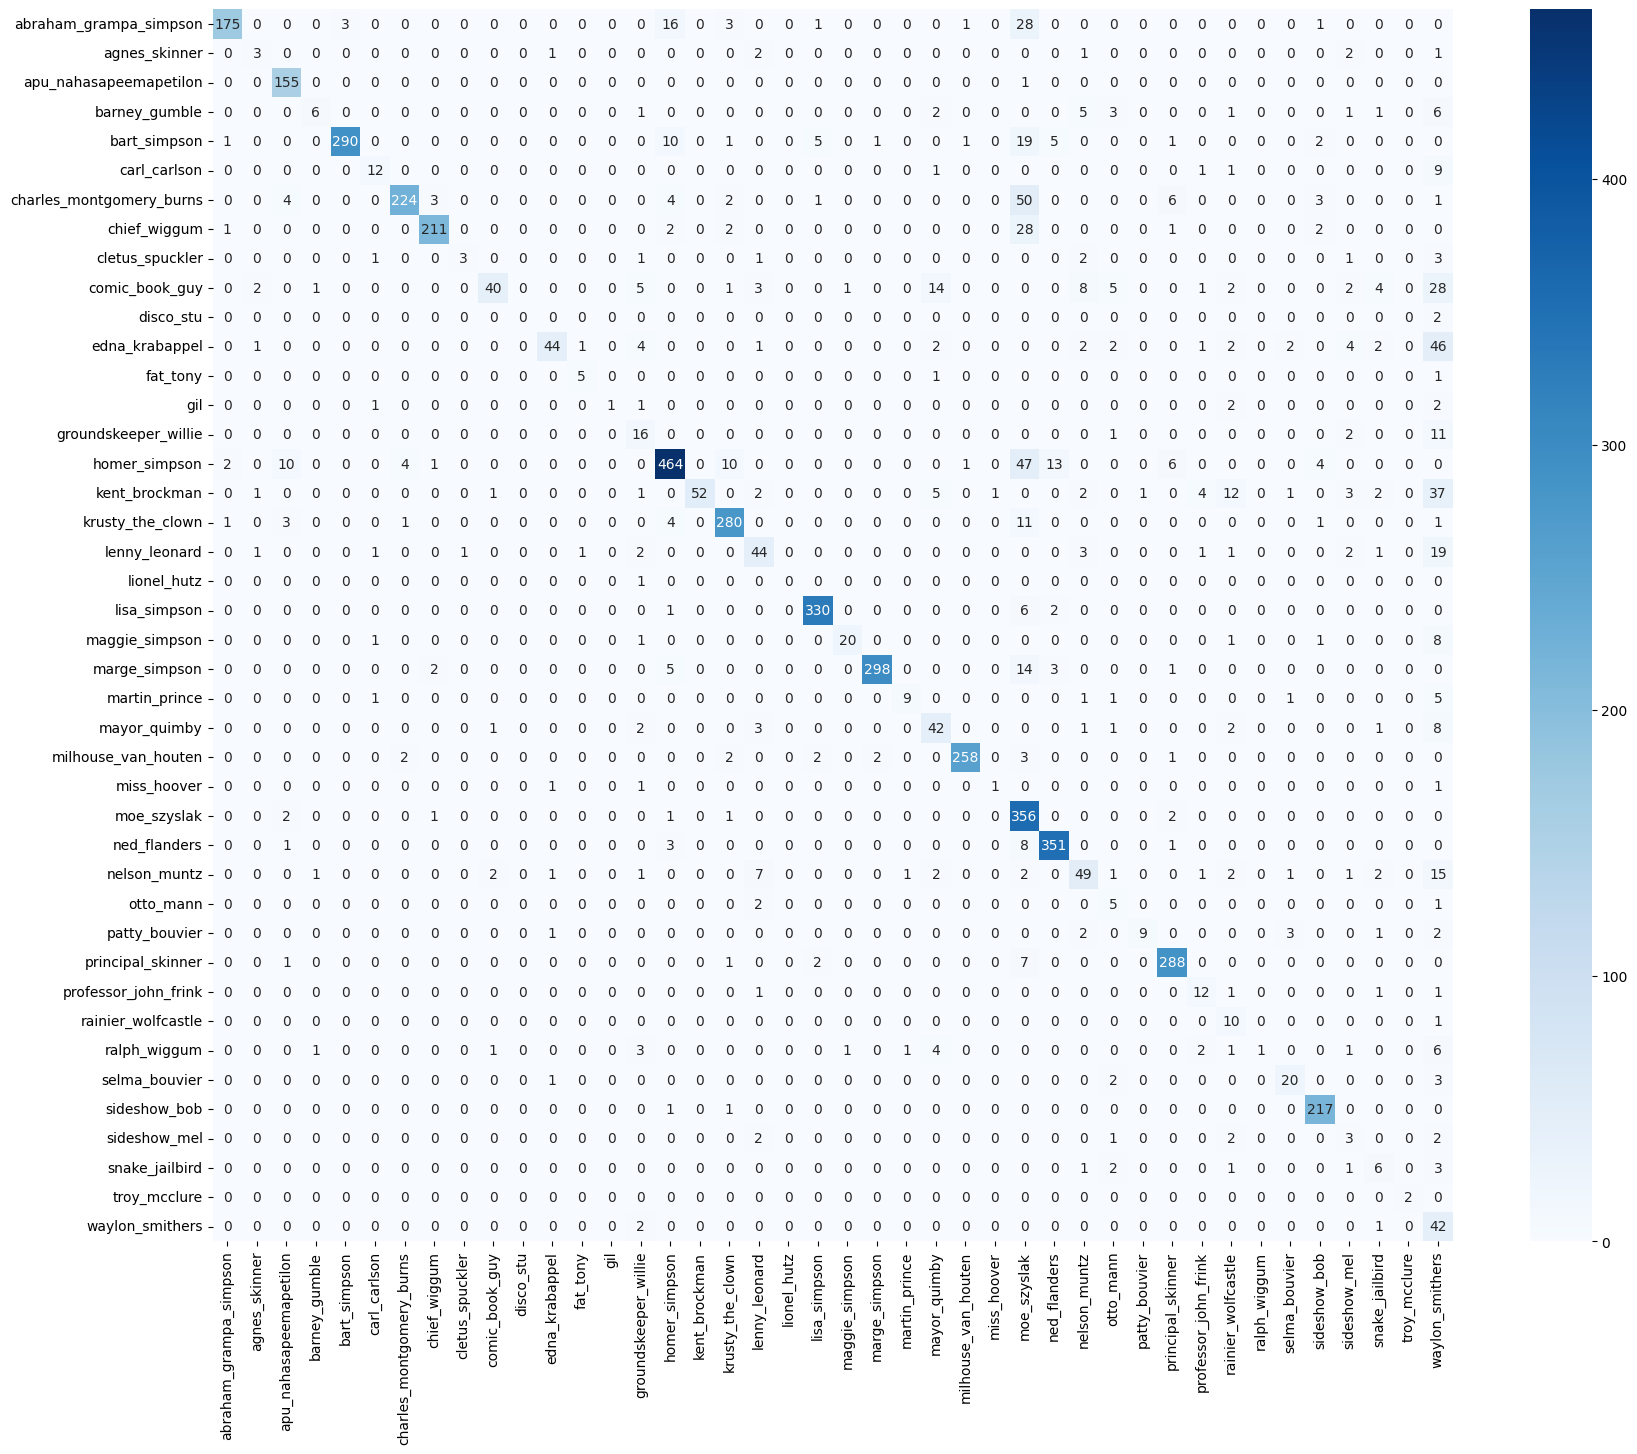

In [44]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_ResNet_2(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

> Точность значительно выросла, "пустых" классов стало меньше, но они по-прежнему остались, возможно это связано с тем, что в валидационной выборке также мало объектов в миноритарных классах.

#### 7. Функция прогноза по картинке URL

In [45]:
import requests
from io import BytesIO
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [46]:
def predict_url(url, model):

    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    response = requests.get(url, verify=False)
    image = Image.open(BytesIO(response.content))
    image_transformed = transform(image)
    plt.imshow(image_transformed.permute(1, 2, 0))
    model.eval()
    with torch.inference_mode():
        model_output = model(image_transformed.reshape((1, 3, 224, 224)).to(device))
    class_label = torch.argmax(model_output, dim=1)
    predicted_class_label = class_names[class_label]
    print(predicted_class_label)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


charles_montgomery_burns


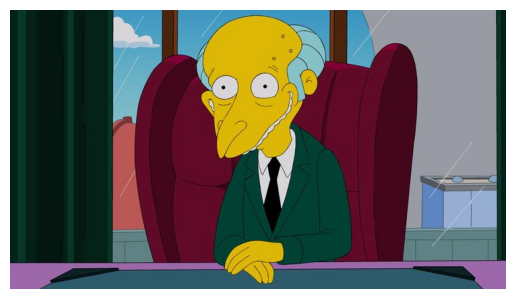

In [47]:
url = 'https://i.pinimg.com/736x/6f/1e/2e/6f1e2e9818ead6328400e3ca78070405.jpg'
predict_url(url, model_ResNet_2)

#### 8. Функция прогноза

In [48]:
def visualization(dataset, model, class_names):

    dataloader = DataLoader(dataset, batch_size=25, shuffle=True)

    images = next(iter(dataloader))

    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    images = images.cpu()
    preds = preds.cpu()

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()
    for img, pred, ax in zip(images, preds, axes):
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Денормализация
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(class_names[pred])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


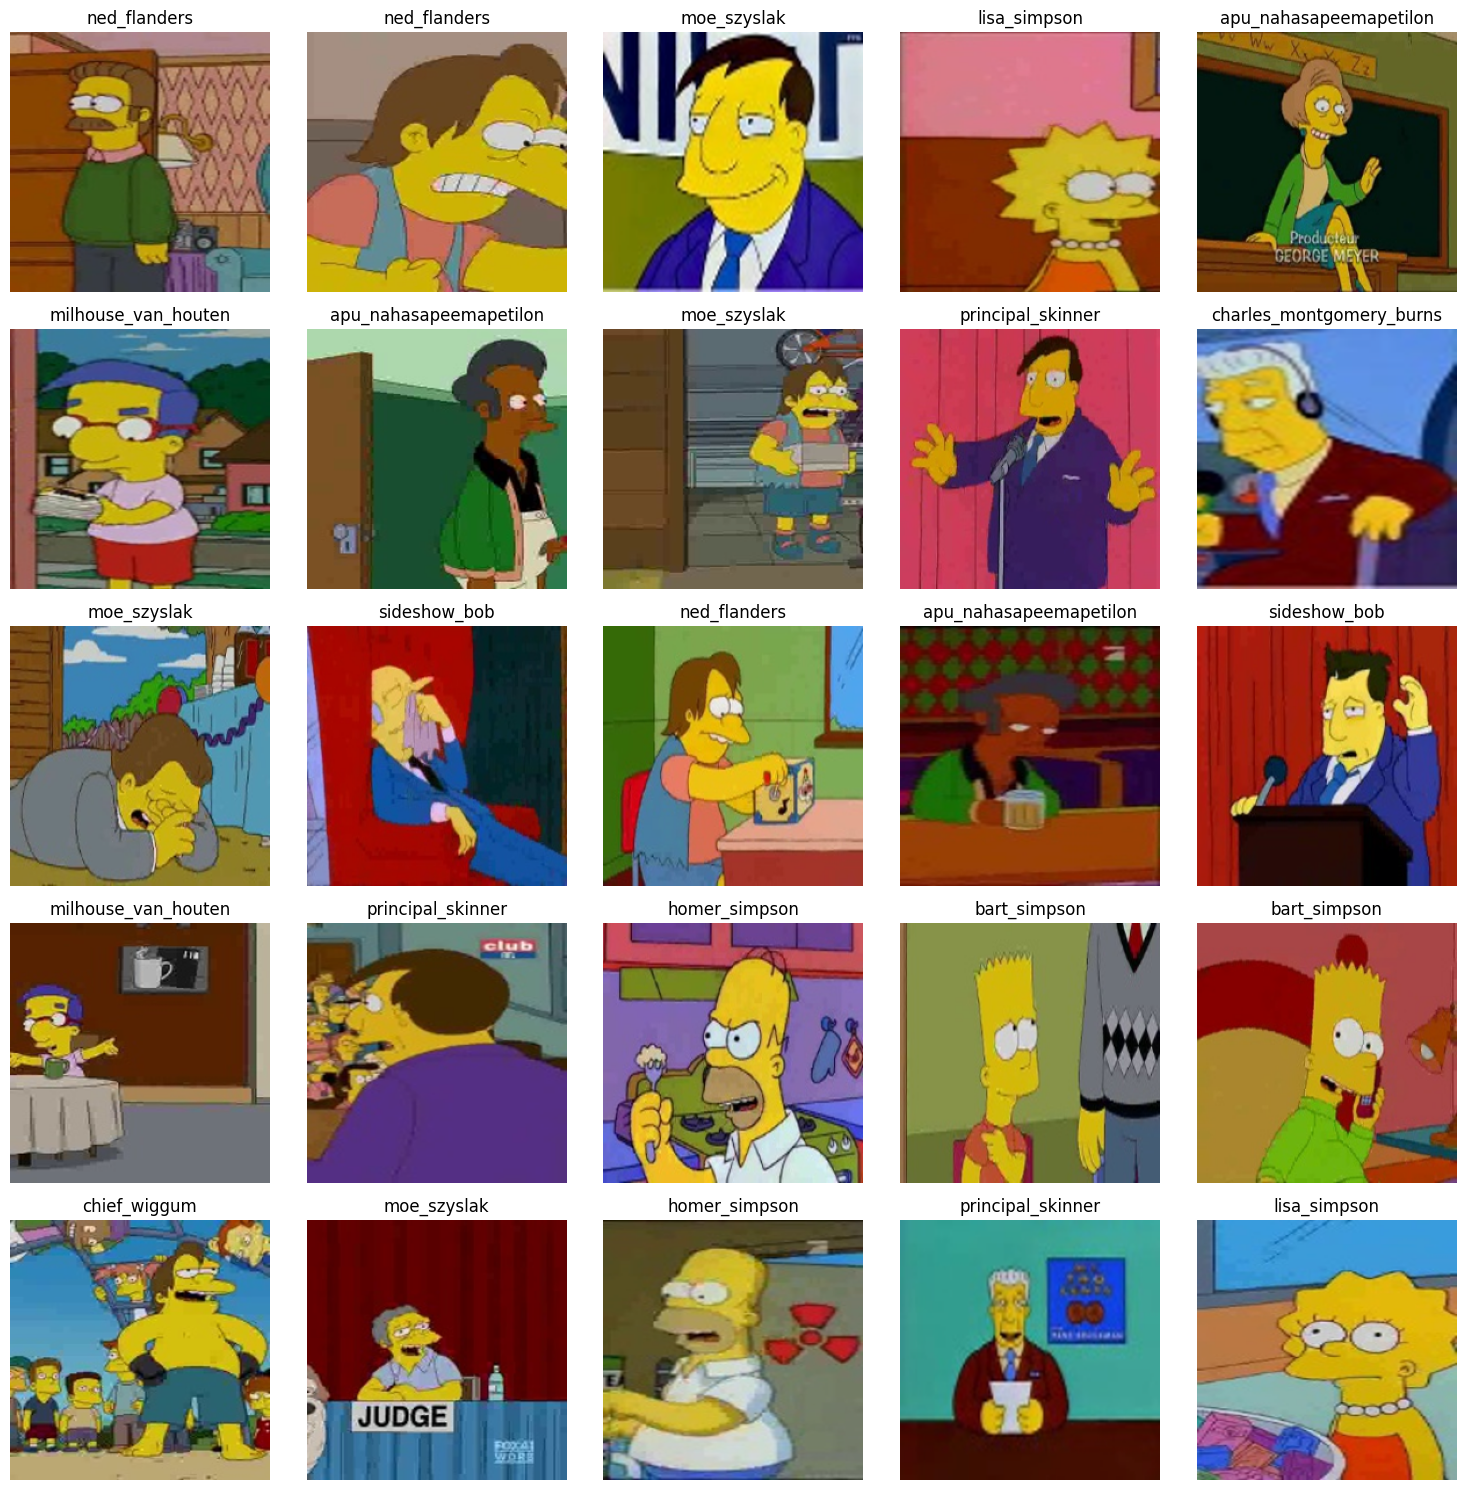

In [49]:
visualization(test_dataset, model_ResNet_2, class_names)

На случайных 25 изображениях модель ошиблась 12 раз, что довольно много.<br><br>
Попробуем обогатить тренировочную выборку другим способом - привести количество объектов к числу объектов максимального класса, скопировав изображения с применением разнообразной аугментации.

#### 9. Обогащение выборки разнообразной аугментацией

In [50]:
from collections import Counter
import shutil

In [51]:
# Определим трансформации для аугментации
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Отражение с вероятностью 50%
    transforms.RandomRotation(degrees=(-15, 15)),  # Поворот на ±15 градусов
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Лёгкие изменения цветов
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),  # Сдвиг, масштаб, сдвиг
    transforms.Resize((256, 256)),  # Приведение всех изображений к единому размеру
    transforms.RandomCrop((224, 224)),  # Центрируем, чтобы уменьшить шум
    transforms.ToTensor(),  # Преобразование в формат PyTorch
])

# Определим папку с изображениями и читаем пути к ним
train_files = list(Path("journey-springfield/train/simpsons_dataset").rglob("*.jpg"))

# Получим метки классов и количество изображений в каждом классе
train_labels = [path.parent.name for path in train_files]
counter = Counter(train_labels)
max_count = 1684  # Максимальное количество изображений на класс

# Создадим папку для увеличенных данных
augmented_data_dir = Path("journey-springfield/augmented_data")
augmented_data_dir.mkdir(exist_ok=True)

# Создадим подкатегории для каждого класса
for label in counter.keys():
    (augmented_data_dir / label).mkdir(exist_ok=True)

total_augmented = 0

# Копируем оригинальные изображения и создаем дополнительные для классов с меньшим количеством изображений
for label, count in counter.items():
    dest_dir = augmented_data_dir / label
    dest_dir.mkdir(exist_ok=True)
    original_images = [file for file in train_files if file.parent.name == label]

    # Копируем оригинальные изображения
    for file in original_images:
        shutil.copy(file, dest_dir / file.name)

    # Если нужно, создаем дополнительные изображения
    if count < max_count:
        additional_files_needed = max_count - count
        total_augmented += additional_files_needed
        for i in range(additional_files_needed):
            source_image = original_images[i % len(original_images)]  # Используем круговой индекс
            new_file = dest_dir / f"{source_image.stem}_aug_{i}.jpg"
            with Image.open(source_image) as original_image:
                augmented_image = transform(original_image.convert("RGB"))  # Убедимся, что это RGB
                augmented_image = transforms.ToPILImage()(augmented_image)  # Преобразуем обратно в PIL
                augmented_image.save(new_file, "JPEG", quality=85)

print(f"Total augmented images created: {total_augmented}")

Total augmented images created: 50357


In [52]:
# Обновим список файлов и метки
train_files = list(augmented_data_dir.glob('**/*.jpg'))
train_labels = [path.parent.name for path in train_files]

In [53]:
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")

Количество объектов в каждом классе тренировочной выборки:
Класс abraham_grampa_simpson, количество 1684, доля 2.36%
Класс agnes_skinner, количество 1684, доля 2.36%
Класс apu_nahasapeemapetilon, количество 1684, доля 2.36%
Класс barney_gumble, количество 1684, доля 2.36%
Класс bart_simpson, количество 1684, доля 2.36%
Класс carl_carlson, количество 1684, доля 2.36%
Класс charles_montgomery_burns, количество 1684, доля 2.36%
Класс chief_wiggum, количество 1684, доля 2.36%
Класс cletus_spuckler, количество 1684, доля 2.36%
Класс comic_book_guy, количество 1684, доля 2.36%
Класс disco_stu, количество 1684, доля 2.36%
Класс edna_krabappel, количество 1684, доля 2.36%
Класс fat_tony, количество 1684, доля 2.36%
Класс gil, количество 1684, доля 2.36%
Класс groundskeeper_willie, количество 1684, доля 2.36%
Класс homer_simpson, количество 2246, доля 3.15%
Класс kent_brockman, количество 1684, доля 2.36%
Класс krusty_the_clown, количество 1684, доля 2.36%
Класс lenny_leonard, количество 1684, 

In [54]:
train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [55]:
weights_ResNet = models.ResNet18_Weights.DEFAULT
model_ResNet_3 = models.resnet18(weights=weights_ResNet)
model_ResNet_3.fc = nn.Linear(512, len(class_names))

In [56]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ResNet_3.parameters(), lr=1e-4)
model_ResNet_3, train_time = train(model_ResNet_3, train_loader, val_loader, loss_fn, optimizer, 15)

Эпоха 1
Функция потерь (кросс-энтропия) на данных 0.1356426650035712
Точность на данных 0.9642720672525793
Эпоха 2
Функция потерь (кросс-энтропия) на данных 0.11828707619558022
Точность на данных 0.9658005349636989
Эпоха 3
Функция потерь (кросс-энтропия) на данных 0.10416766794686273
Точность на данных 0.9701948796331678
Эпоха 4
Функция потерь (кросс-энтропия) на данных 0.10327537463688476
Точность на данных 0.9705769965609476
Эпоха 5
Функция потерь (кросс-энтропия) на данных 0.06445755715839592
Точность на данных 0.9828047382499044
Эпоха 6
Функция потерь (кросс-энтропия) на данных 0.0785738397918066
Точность на данных 0.9764998089415361
Эпоха 7
Функция потерь (кросс-энтропия) на данных 0.0670758248024937
Точность на данных 0.9786014520443256
Эпоха 8
Функция потерь (кросс-энтропия) на данных 0.06647906565947467
Точность на данных 0.981085212074895
Эпоха 9
Функция потерь (кросс-энтропия) на данных 0.08819070372076783
Точность на данных 0.9721054642720672
Эпоха 10
Функция потерь (кросс-э

In [57]:
RESNET3 = MODEL_PATH / "resnet_model_3.pth"
torch.save(obj=model_ResNet_3.state_dict(),
           f=RESNET3)

In [58]:
accuracy_ResNet_3 = round(evaluate(model_ResNet_3, val_loader, loss_fn)[1],2)
ResNet_3_results = {'model': 'ResNet 3.0', 'accuracy': {accuracy_ResNet_3}, 'time': {train_time}}

Функция потерь (кросс-энтропия) на данных 0.0446849071636833
Точность на данных 0.9870080244554834


In [59]:
Result_AlexNet = {'model': 'AlexNet', 'accuracy': {0.78}, 'time': {1752}}
Result_VGG19 = {'model': 'VGG19', 'accuracy': {0.76}, 'time': {4994}}
Result_ResNet = {'model': 'ResNet', 'accuracy': {0.82}, 'time': {1841}}
Result_ResNet2 = {'model': 'ResNet oversamling', 'accuracy': {0.88}, 'time': {7964}}
results.loc[len(results)] = Result_AlexNet
results.loc[len(results)] = Result_VGG19
results.loc[len(results)] = Result_ResNet
results.loc[len(results)] = Result_ResNet2

In [60]:
results.loc[len(results)] = ResNet_3_results

In [61]:
print(results)

                 model accuracy                  time
0              AlexNet   {0.82}                  1752
1                VGG19   {0.76}                  4994
2               ResNet   {0.82}                  1841
3  ResNet oversampling   {0.83}                  7964
4              AlexNet   {0.78}                {1752}
5                VGG19   {0.76}                {4994}
6               ResNet   {0.82}                {1841}
7   ResNet oversamling   {0.88}                {7964}
8           ResNet 3.0   {0.99}  {27455.549336910248}


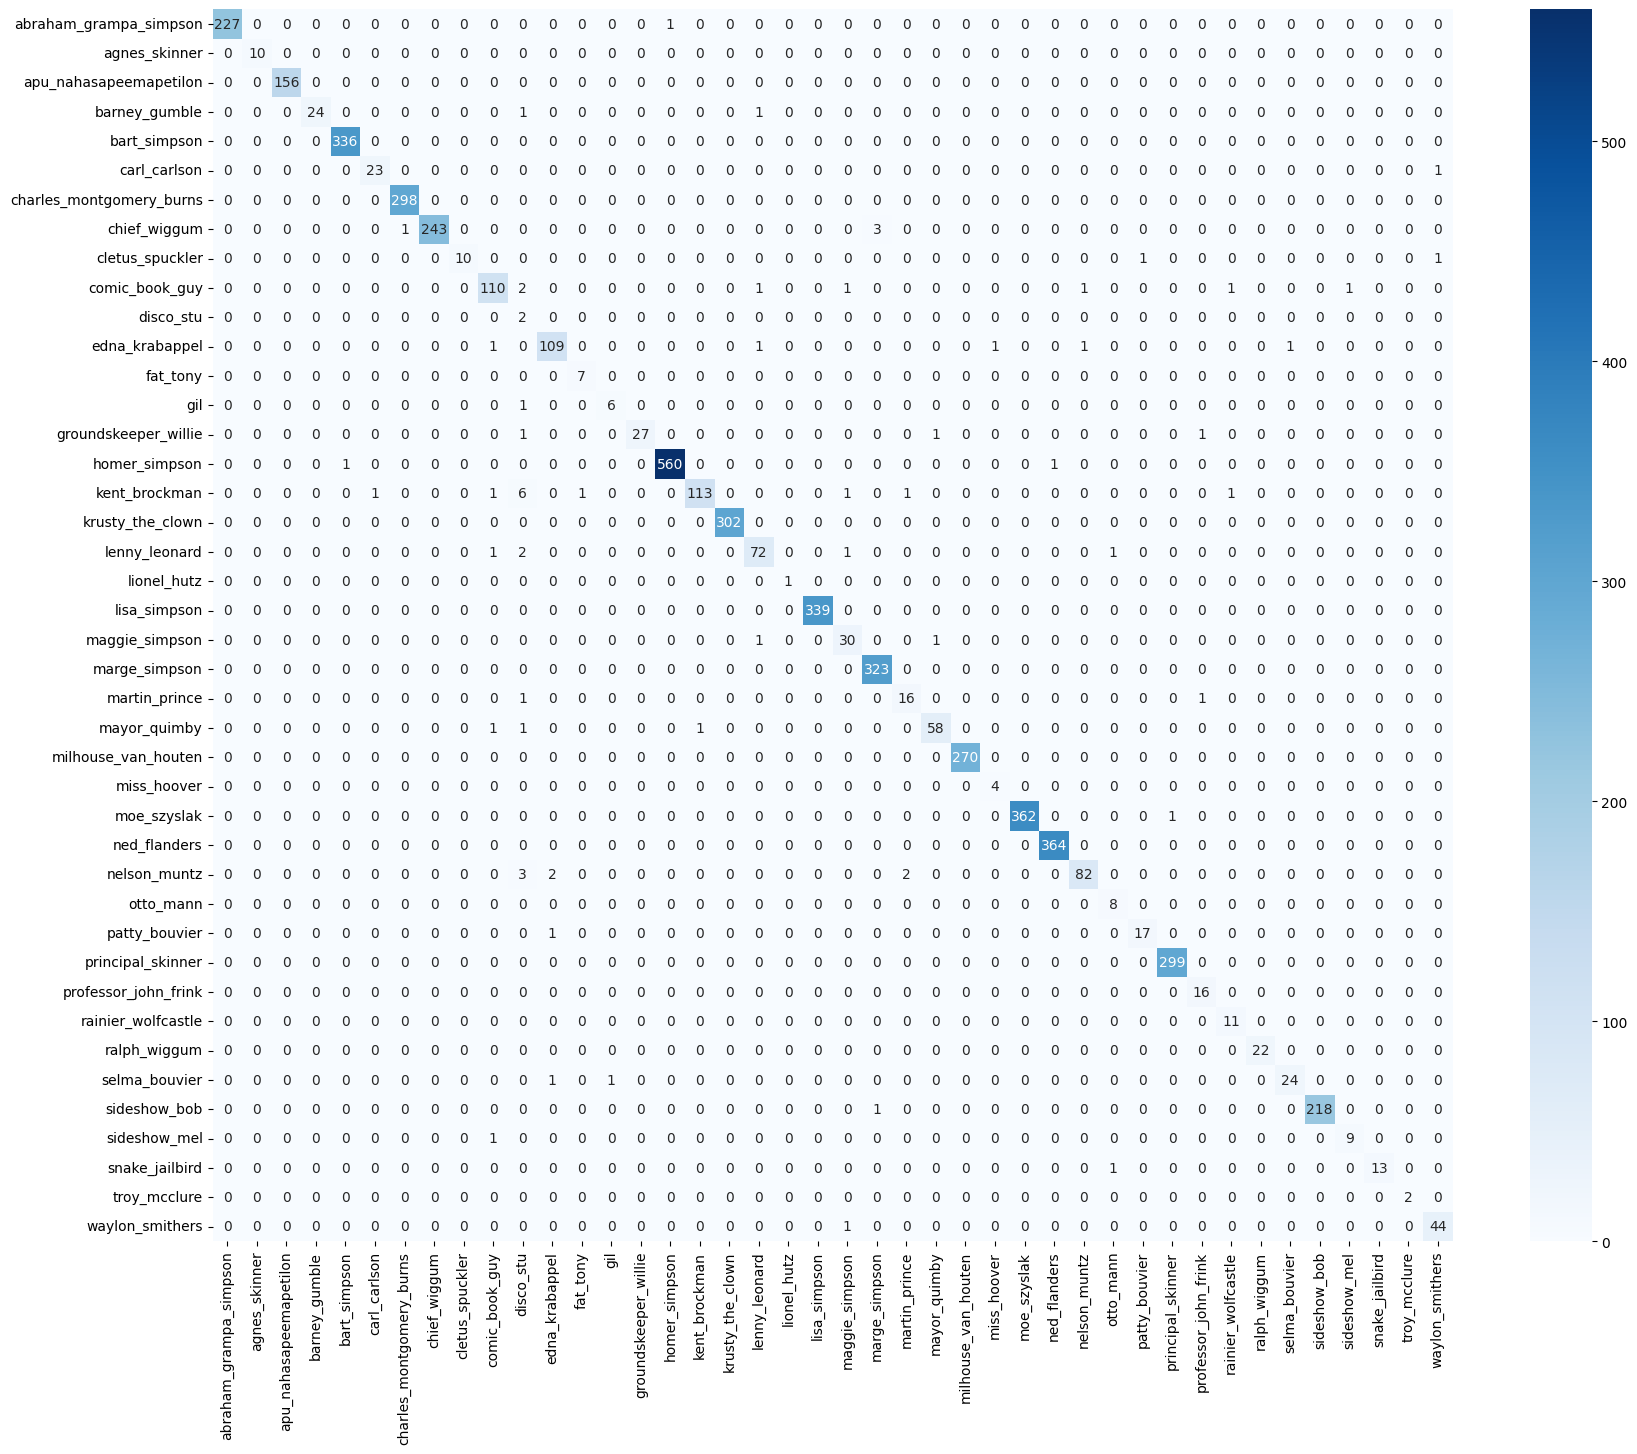

In [62]:
y_val = []
y_predict = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        y_pred = model_ResNet_3(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

conf = confusion_matrix(y_val, y_predict)
showmatrix(conf)

> В результате лучшим способом достичь высшего качество оказалось обогащение выборки с помощью создания объектов с применением аугментации до тех пор, пока число объектов в каждом классе не достигнет максимального класса. Такой подход позволил достичь метрики качества accuracy 98% на валидации.

In [100]:
def visualization_add(dataset, model, class_names):
    dataloader = DataLoader(dataset, batch_size=25, shuffle=True)

    # Пытаемся получить данные из даталоадера
    images = next(iter(dataloader))
    
    if isinstance(images, tuple):  # Если датасет возвращает (изображения, метки)
        images, true_labels = images
        true_labels_available = True
    else:  # Если возвращаются только изображения
        true_labels = None
        true_labels_available = False

    model.eval()
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probabilities, 1)

    images = images.cpu()
    preds = preds.cpu()
    probabilities = probabilities.cpu()

    fig, axes = plt.subplots(5, 5, figsize=(15, 15))
    axes = axes.flatten()

    for i, (img, pred, prob, ax) in enumerate(zip(images, preds, probabilities, axes)):
        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Денормализация
        img = np.clip(img, 0, 1)

        # Формируем заголовок
        if true_labels_available:
            true_label = true_labels[i]
            title = f"Предсказание: {class_names[pred]}\n" \
                    f"Истинное: {class_names[true_label]}\n" \
                    f"Вероятность: {prob[pred]:.2f}"
        else:
            title = f"Предсказание: {class_names[pred]}\n" \
                    f"Вероятность: {prob[pred]:.2f}"

        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

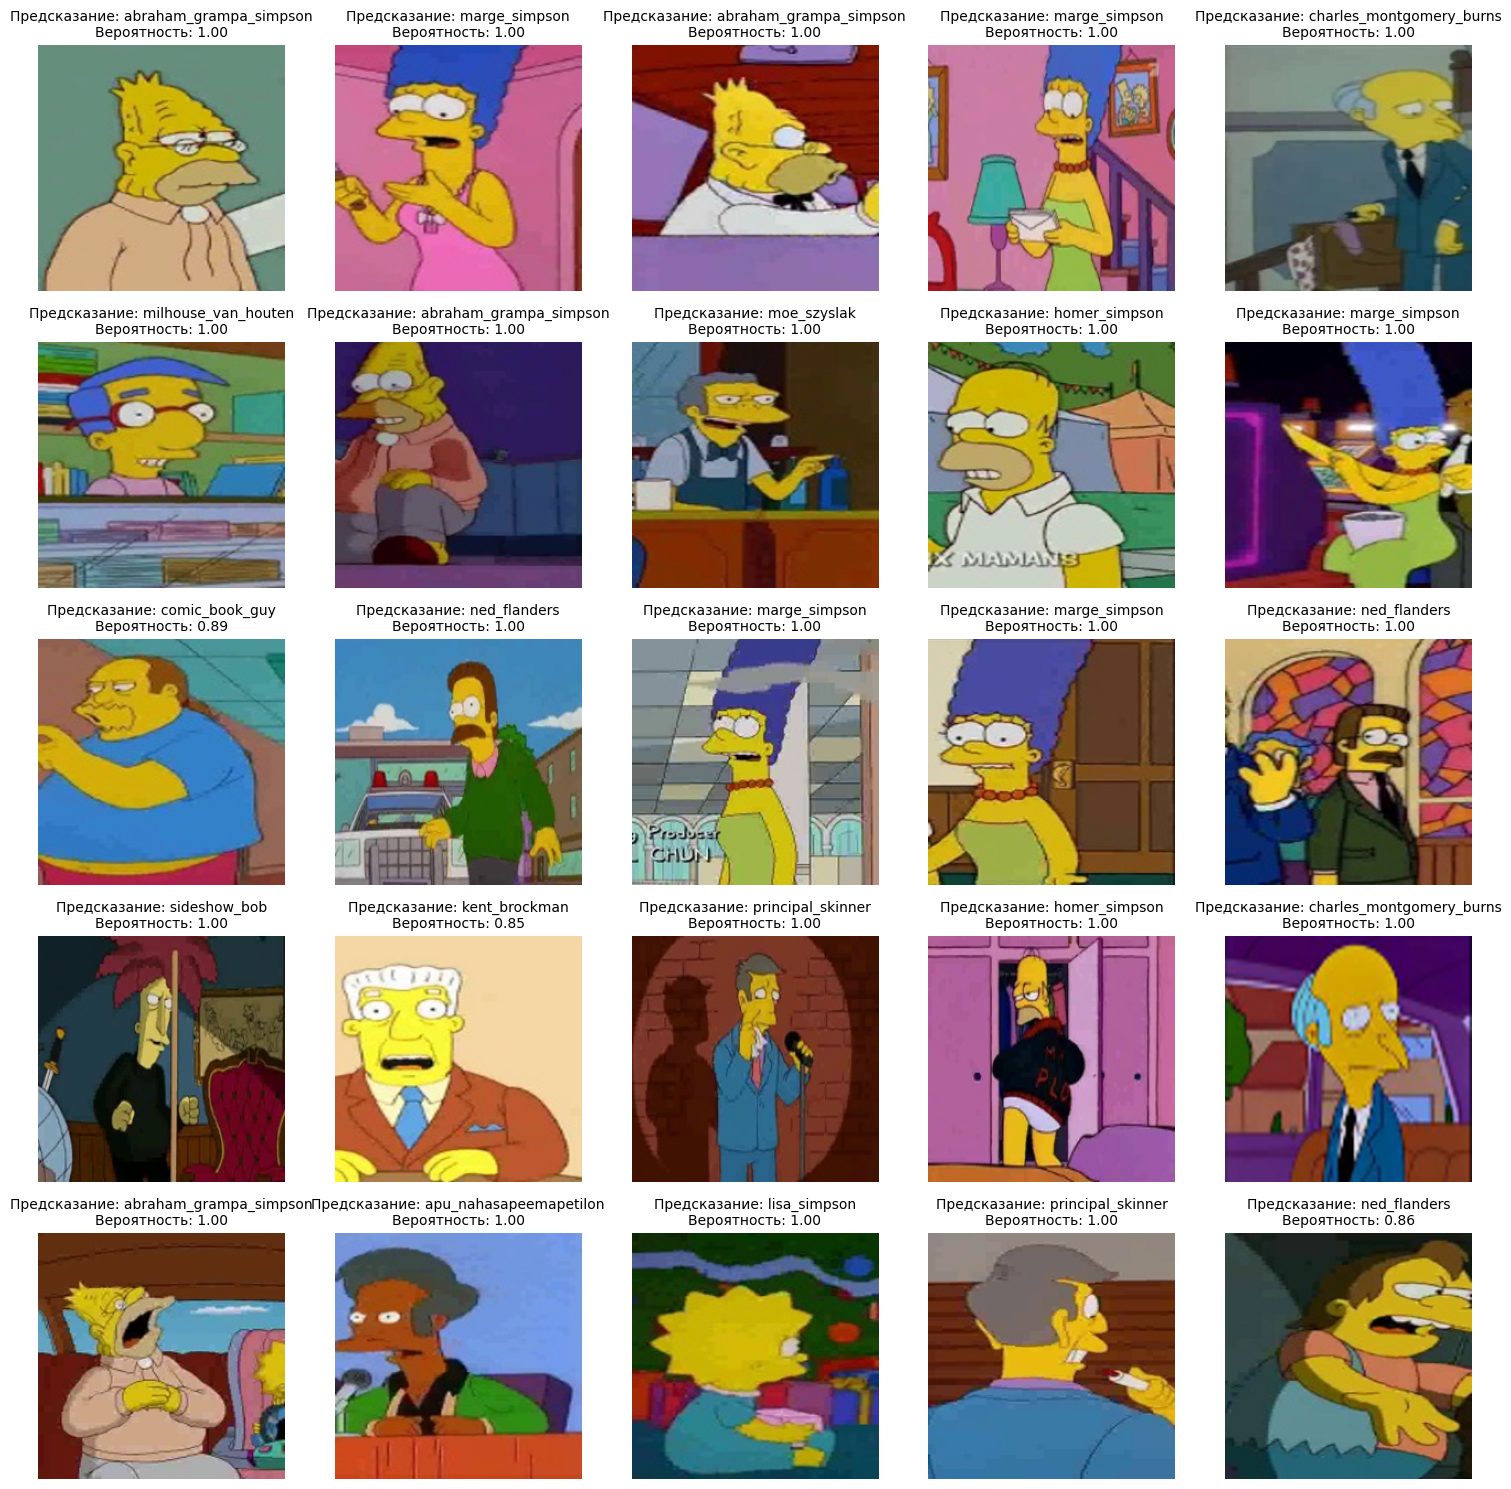

In [103]:
visualization_add(test_dataset, model_ResNet_3, class_names)

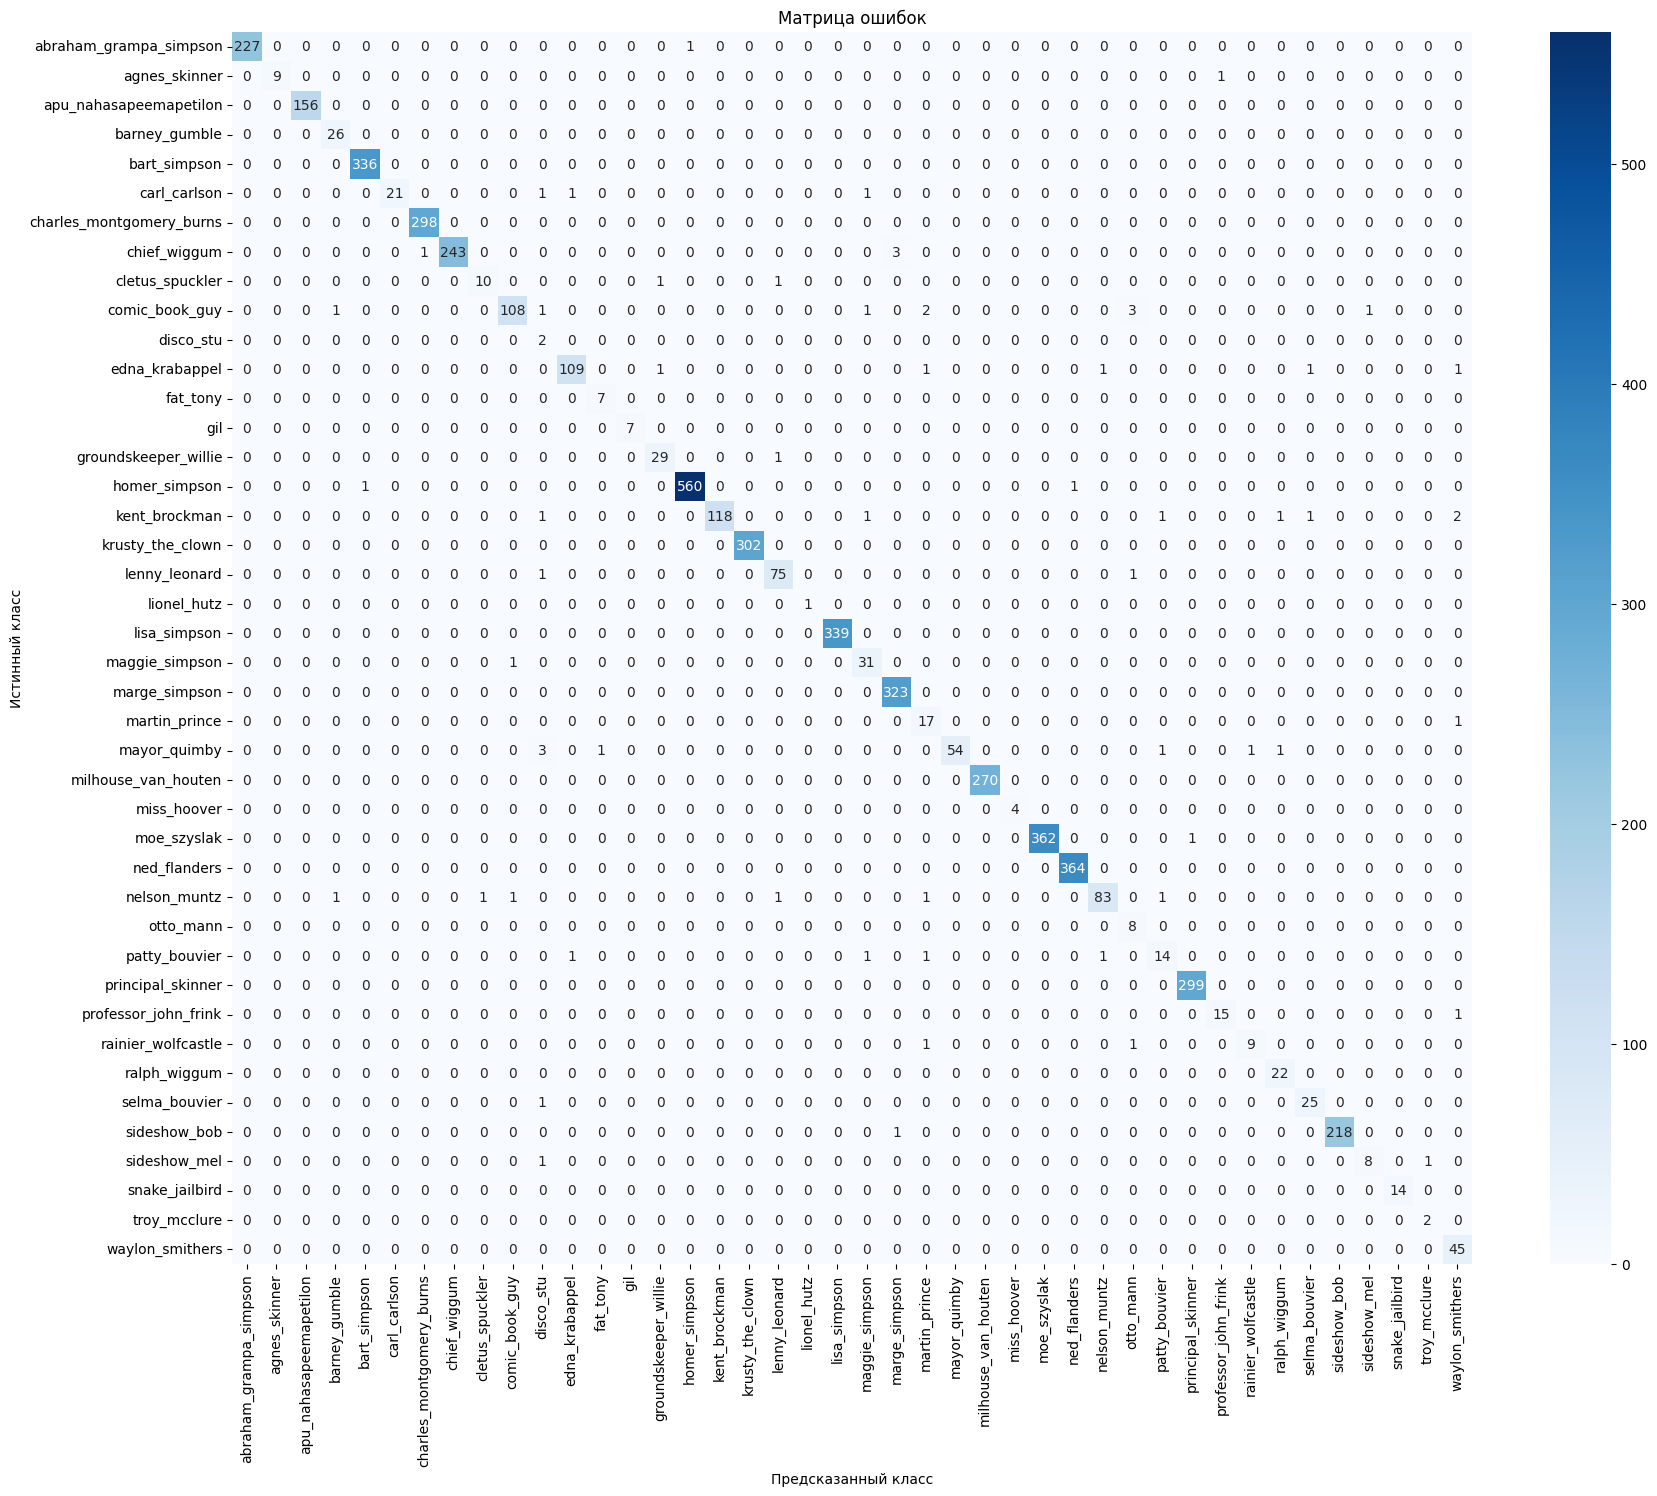

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def showmatrix_add(conf, class_names):
    df_conf = pd.DataFrame(conf,
                           index=class_names,
                           columns=class_names)
    plt.figure(figsize=(20, 16))
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")
    plt.title("Матрица ошибок")
    plt.show()

# Создание массивов для меток
y_val = []
y_predict = []

# Предсказания модели
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Получение предсказаний
        y_pred = model_ResNet_3(images)
        y_pred_classes = y_pred.argmax(dim=1).cpu().numpy()
        labels_cpu = labels.cpu().numpy()

        # Сохранение меток
        y_val.extend(labels_cpu)
        y_predict.extend(y_pred_classes)

# Построение матрицы ошибок
conf = confusion_matrix(y_val, y_predict, labels=range(len(class_names)))
showmatrix_add(conf, class_names)